# Проект: классификация

In [1483]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

import plotly
import plotly.express as px
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None) 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)
import plotly.io as pio
pio.renderers.default = "notebook_connected"

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [1484]:
df = pd.read_csv('bank_fin.csv', sep = ';')

In [1485]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [1486]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [1487]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isna().sum().sort_values(ascending=False)

balance      25
age           0
day           0
poutcome      0
previous      0
pdays         0
campaign      0
duration      0
month         0
contact       0
job           0
loan          0
housing       0
default       0
education     0
marital       0
deposit       0
dtype: int64

### Задание 2

In [1488]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
print(df['job'].nunique())
print(df['job'].unique())
print(df['job'].value_counts())

12
['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']
job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64


### Задание 3

In [1489]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].str.replace(',00','')
df['balance'] = df['balance'].str.replace('$','')
df['balance'] = df['balance'].str.replace(' ','')
df['balance']= df['balance'].astype('float64')
print('Среднее по столбцу баланс:', round(df['balance'].mean(), 3))

Среднее по столбцу баланс: 1529.129


In [1490]:
#df.head()

### Задание 4

In [1491]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df['balance'] = df['balance'].fillna(df['balance'].median())
print('Среднее по признаку balance:', round(df['balance'].mean(), 3))

Среднее по признаку balance: 1526.936


### Задание 5

In [1492]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
df_job = df['job'].mode()[0]
df_edu = df['education'].mode()[0]

df['job'] = df['job'].apply(lambda x: df_job if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: df_edu if x == 'unknown' else x)
print(round(df[(df['education']=='secondary') & (df['job']=='management')]['balance'].mean(),3))

1598.883


### Задание 6

In [1493]:
# удалите все выбросы для признака balance
# ваш код
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, upper_bound, lower_bound

outliers, df, upper_bound, lower_bound = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df.shape[0]}')
print(f'Верхняя граница: {upper_bound} Нижняя граница: {lower_bound}')

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105
Верхняя граница: 4063.0 Нижняя граница: -2241.0


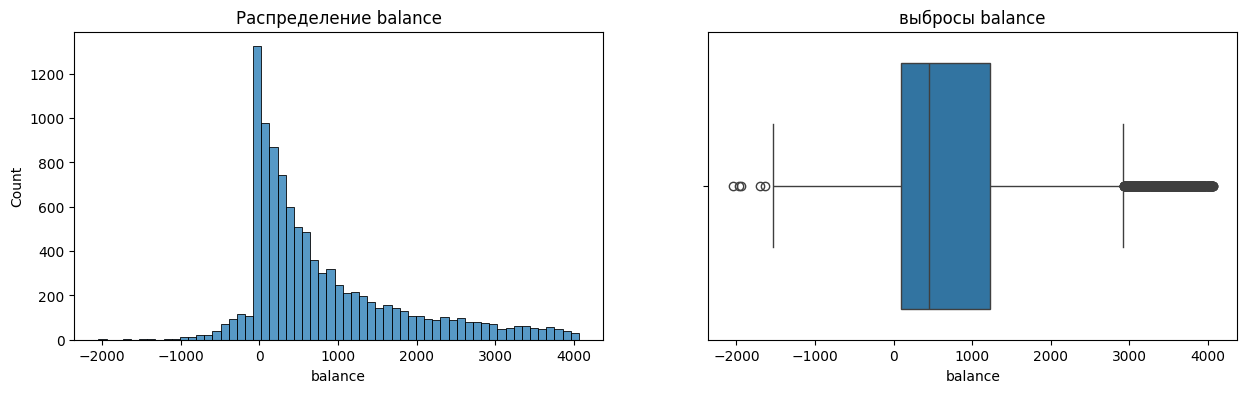

In [1494]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0]);
histplot.set_title('Распределение balance');
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1]);
boxplot.set_title('выбросы balance');

## Часть 2:  Разведывательный анализ

### Задание 1

In [1495]:
import plotly.express as px

In [1496]:
#fig = px.histogram(df, x='deposit', title='deposit', text_auto=True)
#fig.show('png')

deposit
no     0.536764
yes    0.463236
Name: proportion, dtype: float64

<Axes: xlabel='deposit', ylabel='count'>

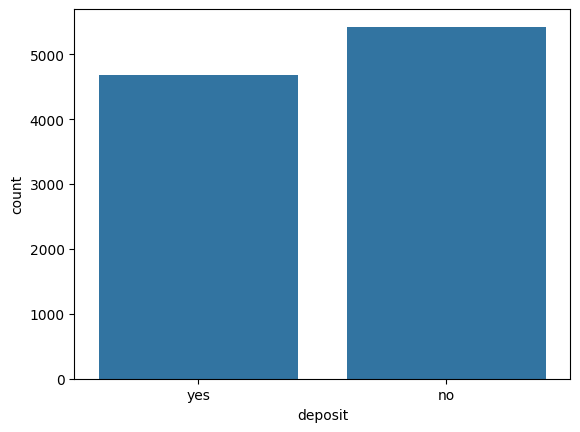

In [1497]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
display(df['deposit'].value_counts(normalize=True))
sns.countplot(data=df, x='deposit')

Классы относительно сбалансированы.

### Задания 2 и 3

In [1498]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
print('Максимальный возраст клиента:', df['age'].max()), \
print('Mинимальная продолжительность разговора с клиентом банка:', df['duration'].min())
df.describe()

Максимальный возраст клиента: 95
Mинимальная продолжительность разговора с клиентом банка: 2


,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


In [1499]:
df.describe(include = 'object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


In [1500]:
display(df['poutcome'].value_counts())

poutcome
unknown    7570
failure    1109
success     945
other       481
Name: count, dtype: int64

In [1501]:
#df.groupby('deposit').mean()   # Влияние количественных переменных на депозит

<Axes: xlabel='deposit', ylabel='balance'>

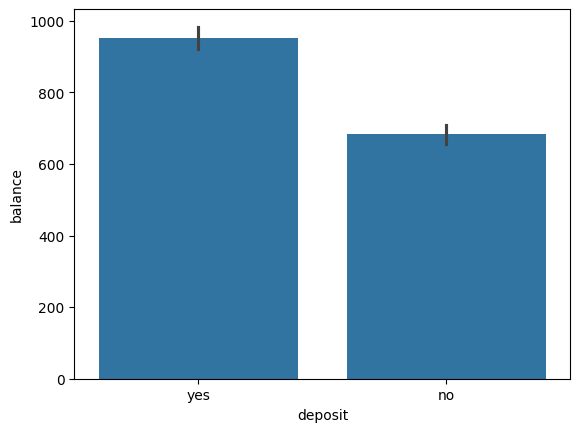

In [1502]:
# влияние баланса на наличие депозита
sns.barplot(x='deposit', y='balance', data=df)

Вывод: Количество клиентов, имеющих депозит, обладают большим балансом, что позволяет делать накопления и формировать депозит. Соответственно, зависимость наличия депозита от баланса прямопропорциональная.

Зависимость баланса от различных факторов.

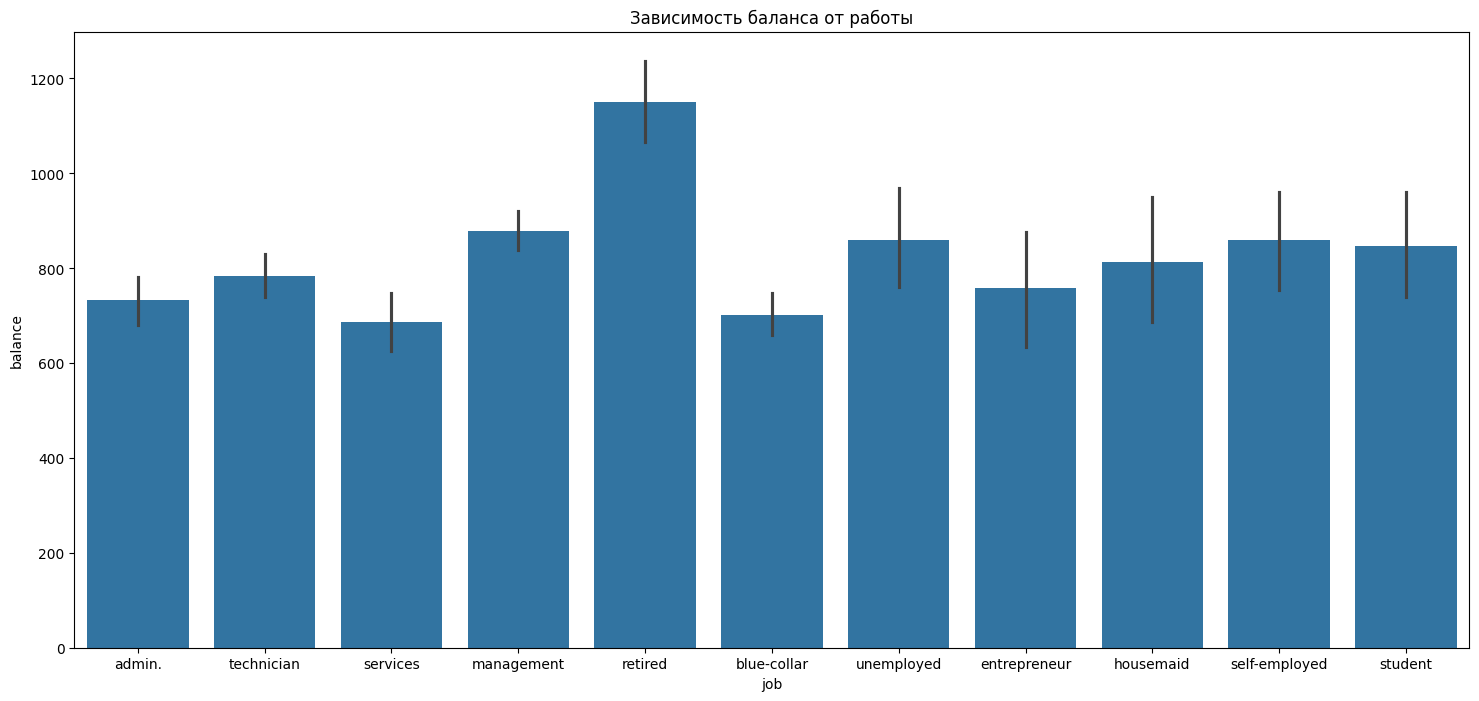

In [1503]:
# зависимость от типа работы
fig = plt.figure(figsize=(18, 8))
g = sns.barplot(
    data = df,
    x = 'job',
    y = 'balance'
)
g.set_title('Зависимость баланса от работы');

Баланс зависит от вида работы. Наибольший баланс у пенсионеров, наименьший у работников в сфере услуг.

In [1504]:
# зависимость от типа работы и образования/
data = df[df['deposit']=='yes']
data = data.pivot_table('balance', index ='job', columns='education', aggfunc='mean')
data

education,primary,secondary,tertiary
job,,,
admin.,643.000000,867.162791,829.370787
blue-collar,749.020305,809.326389,670.782609
entrepreneur,563.500000,951.288462,954.040816
housemaid,1157.586957,898.529412,1168.263158
management,1053.421053,1142.834437,1033.756477
retired,1347.400000,1163.201031,1414.443182
self-employed,457.000000,712.609756,1102.758621
services,852.703704,768.538721,787.952381
student,885.857143,810.346154,996.000000


Text(0.5, 1.0, 'Зависимость баланса от работы и образования')

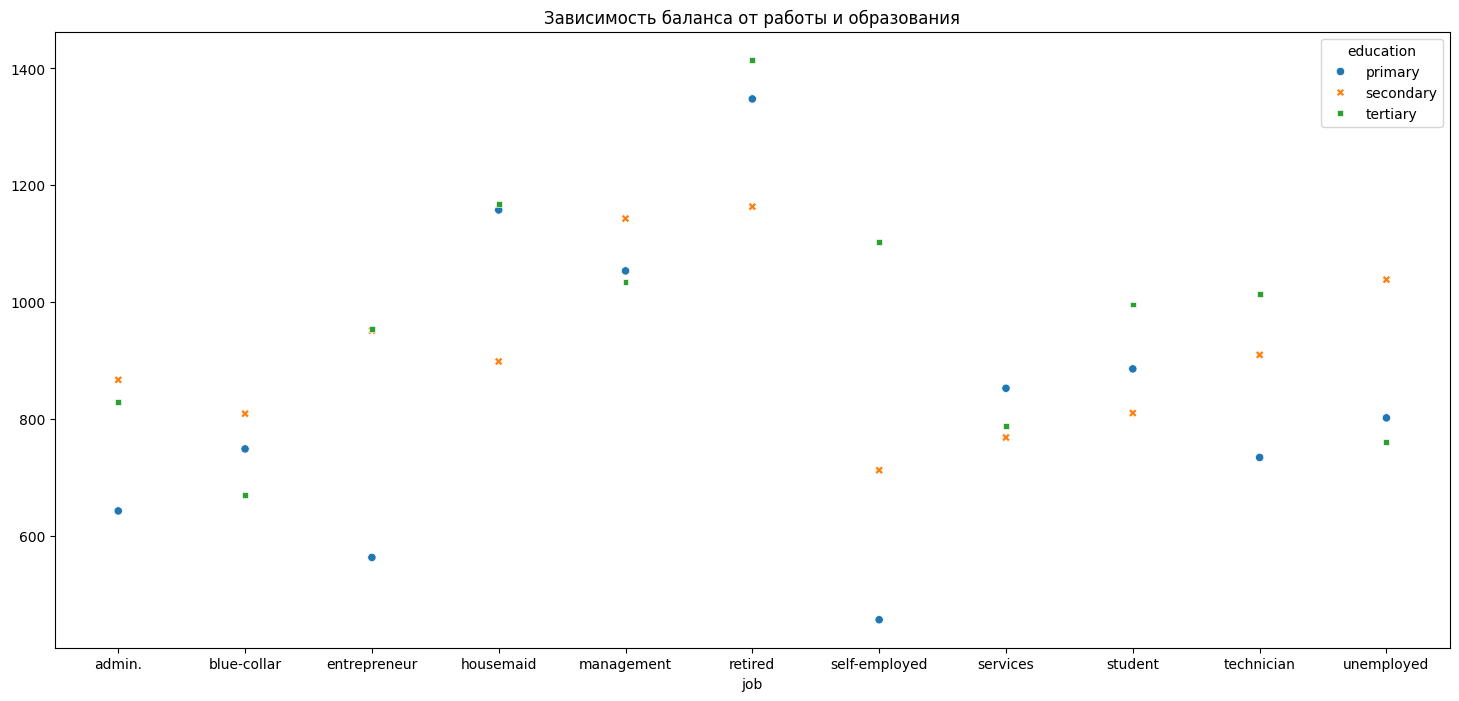

In [1505]:
fig = plt.figure(figsize=(18, 8))
g = sns.scatterplot(data)
g.set_title('Зависимость баланса от работы и образования')

Не во всех сферах деятельности прямая прямопорциональная зависимость баланса от уровня образования.

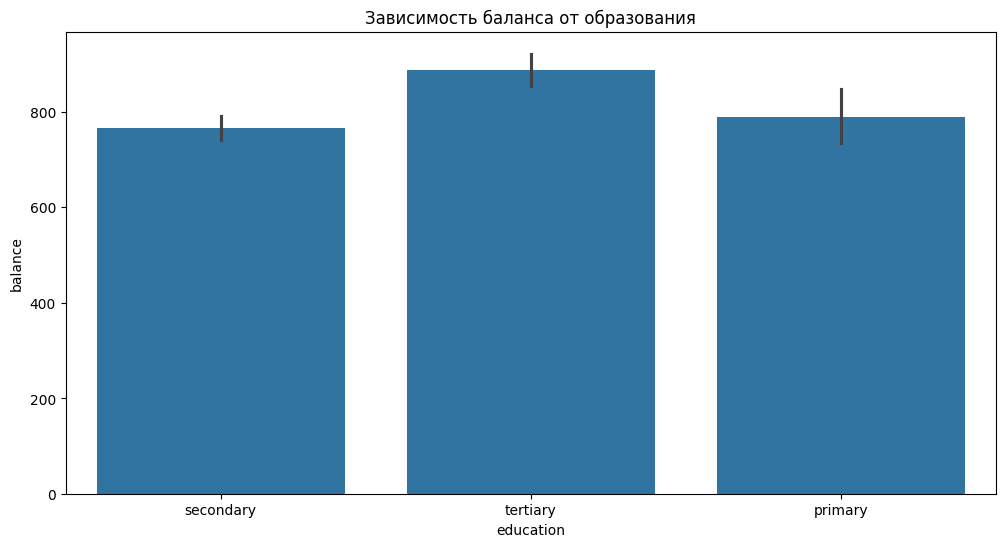

In [1506]:
fig = plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data = df,
    x = 'education',
    y = 'balance'
)
barplot.set_title('Зависимость баланса от образования');

Наблюдается влияние образования на баланс, клиенты с высшим образованием имеют больший баланс. У клиентов со средним образованием баланс ниже, чем у тех, кто имеет начальное образование.

Распределение возраста клиентов

Text(0.5, 1.0, 'Возраст клиентов банка')

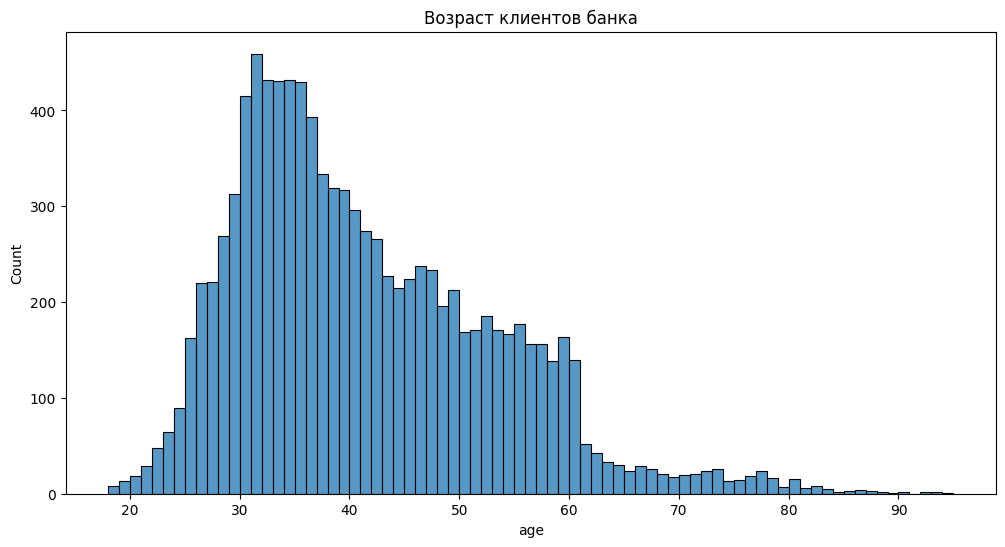

In [1507]:
fig = plt.figure(figsize=(12, 6))
g = sns.histplot(data=df['age'], binwidth=1)
g.set_title('Возраст клиентов банка')

Данные в признаке age распределены лог-нормально. Минимальный возраст клиента банка 18 лет, максимальный 95, медианный возраст 38, средний 41. Следует разделить клиентов на несколько возрастных категорий, например до 30, 30-40, 41-50, 51-60 и старше 60

Text(0.5, 1.0, 'Баланс')

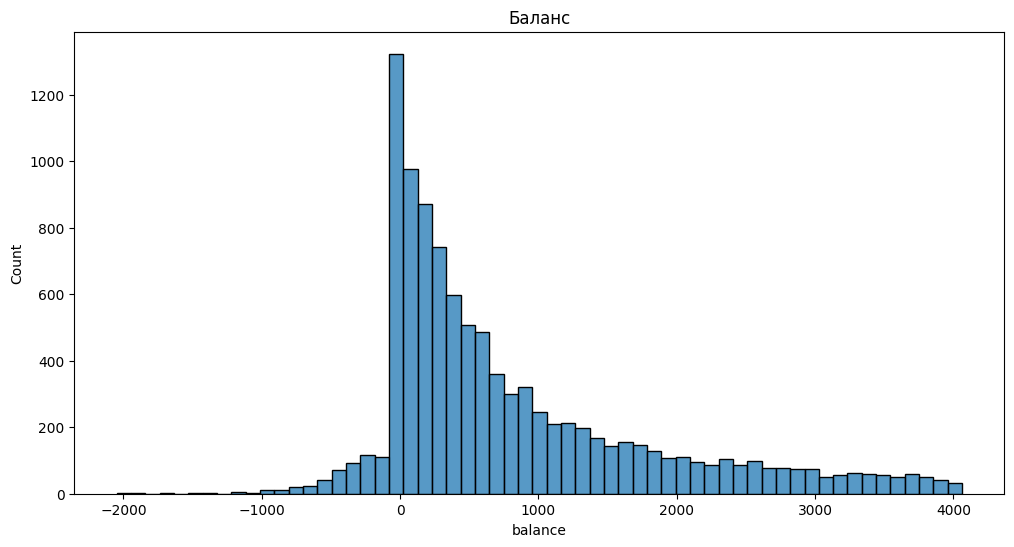

In [1508]:
fig = plt.figure(figsize=(12, 6))
g = sns.histplot(data=df['balance'])
g.set_title('Баланс')

Данные в признаке balance распределены лог-нормально. 

Наименьший баланс -2049, наибольший 4063, медианный 445.

Часть клиентов имеютотрицательный баланс.
Следует выделить их в отдельную категорию. Также в отдельную категорию нужно выделить клиентов с нулевым балансом и добавить несколько категорий для всех остальных клиентов: 
1. от 100 до 500
2. от 500 до 1000
3. более 1000 

Text(0.5, 1.0, 'День последнего контакта')

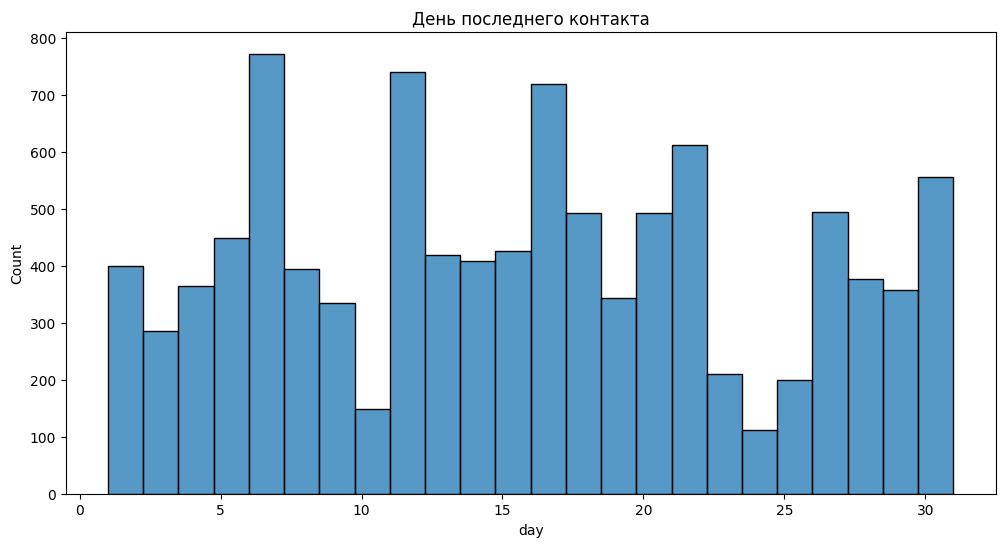

In [1509]:
fig = plt.figure(figsize=(12, 6))
g = sns.histplot(data=df['day'])
g.set_title('День последнего контакта')

Данные в признаке day распределены не равномерно. Этот признак не несет полезной информации, но из него можно получить такие признаки как месяц, год, день недели или признак того, что этот день будним или выходным.

Text(0.5, 1.0, 'Продолжительность контакта (секунд)')

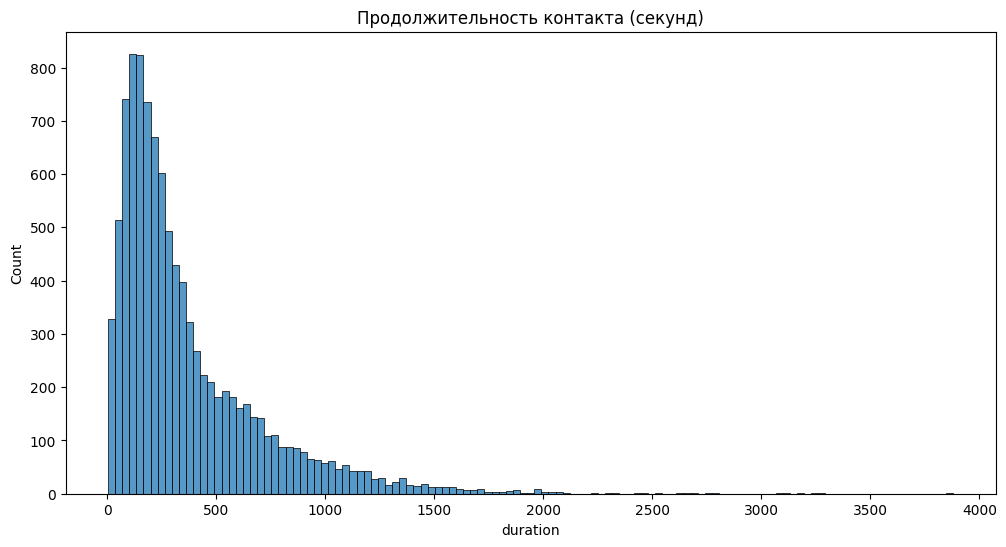

In [1510]:
fig = plt.figure(figsize=(12, 6))
g = sns.histplot(data=df['duration'])
g.set_title('Продолжительность контакта (секунд)')

Данные в признаке duration распределены логнормально. Есть контакты с малой продолжительностью, их следует выделить в отдельную категорию. Остальные контакты можно также распределить по категориям, например до 10 секунд (слишком короткие), от 10 до 60 секунд, от 60 до 180 (3 минуты) секунд, от 180 до 240 (8 минут) секунд, от 240 до 780 (13 минут), больше 780 секунд.

Text(0.5, 1.0, 'Кол-во контактов в текущей компании')

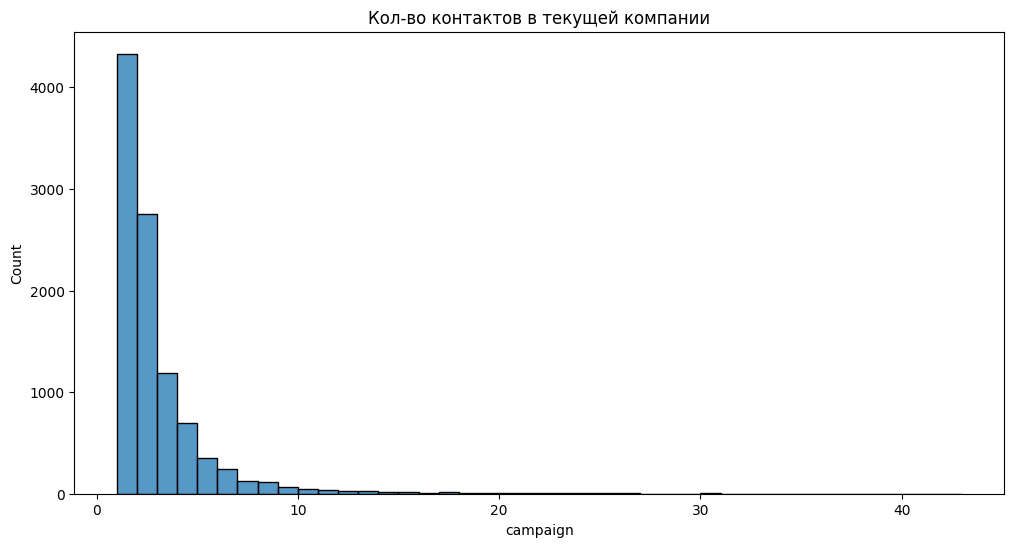

In [1511]:
fig = plt.figure(figsize=(12, 6))
g = sns.histplot(data=df['campaign'], binwidth=1)
g.set_title('Кол-во контактов в текущей компании')

Данные в признаке campaign распределены обратно экспоненциально. Большинство значений в этом признаке равны 1, 2 и 3. Есть несколько клиентов, с которыми контакировали аномально часто, 20 и более раз. Следует выделить такие данные в отдельную категорию. Остальные данные разбить на категории: 1 контакт, 2 контакта, 3-6 контактов, больше 6 контактов.

Text(0.5, 1.0, 'Первый контакт')

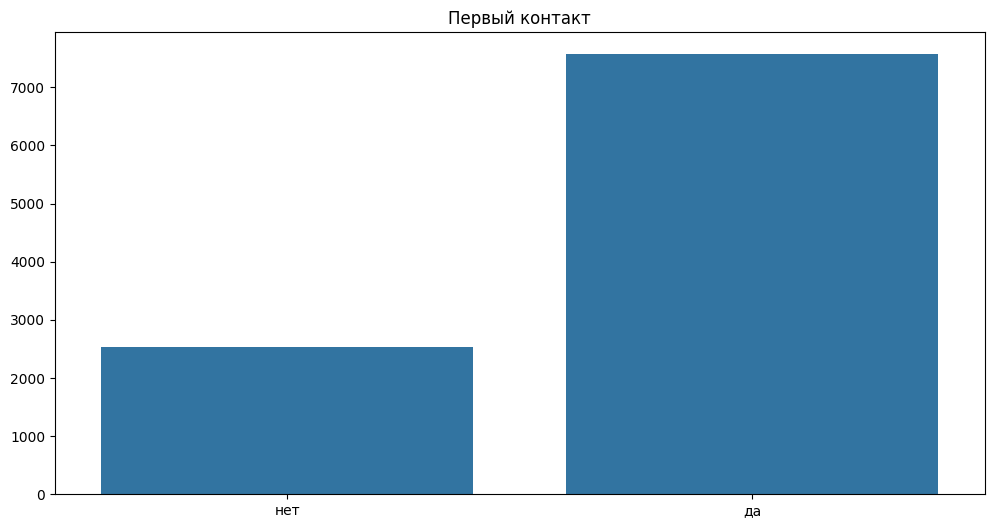

In [1512]:
fig = plt.figure(figsize=(12, 6))
g = sns.barplot(x=['нет', 'да'], y=[df[df['pdays'] > 0].shape[0], df[df['pdays'] < 0].shape[0]])
g.set_title('Первый контакт')

Text(0.5, 1.0, 'Кол-во дней с момента предыдущего контакта (если был)')

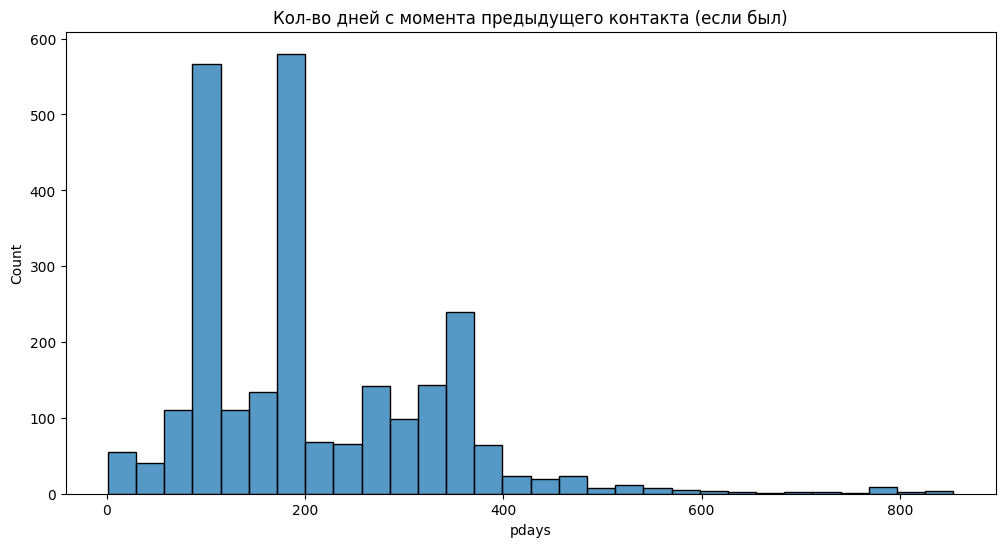

In [1513]:
fig = plt.figure(figsize=(12, 6))
g = sns.histplot(data=(df[df['pdays'] > 0]['pdays']))
g.set_title('Кол-во дней с момента предыдущего контакта (если был)')

В признаке pdays содержится кол-во дней между контактами в текущей маркетинговой кампании и предыдущей. В большинстве случаев это был первый контак с клиентом. Остальные значения изменяются от 1 до 854. Можно видеть три пика, которые приходятся на крупные маркетинговые кампании. Можно разбить данные в признаке на пять категорий: предыдущих контактов не было, от 0 до 100 дней, от 100 до 200 дней, от 200 до 400 дней, больше 400 дней с момента предыдущего контакта.

Text(0.5, 1.0, 'Кол-во контактов до текущей кампании (если были)')

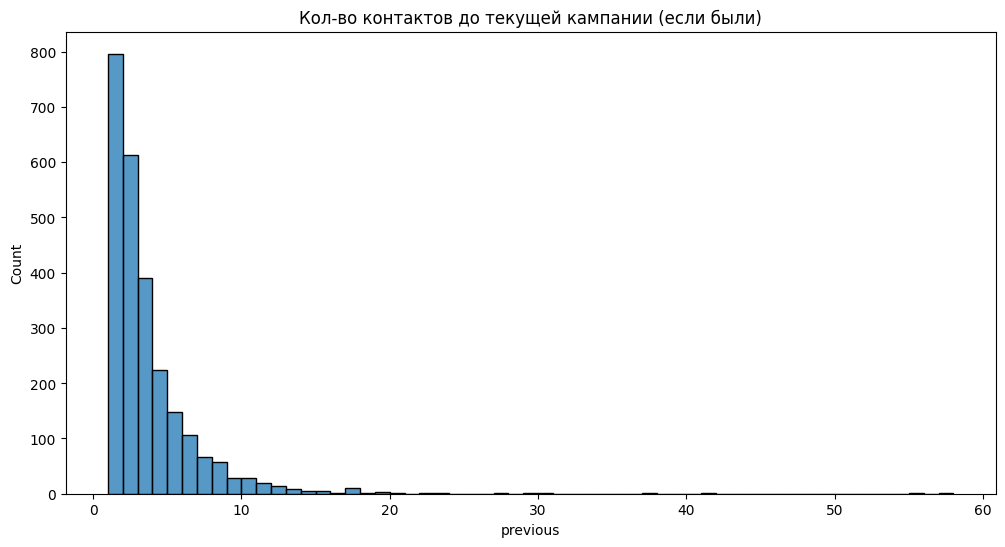

In [1514]:
fig = plt.figure(figsize=(12, 6))
g = sns.histplot(data=(df[df['previous'] > 0]['previous']), binwidth=1)
g.set_title('Кол-во контактов до текущей кампании (если были)')

В признаке previous содерижтся кол-во контактов до текущей кампании. Большинство значений в признаке равны нулю, что означает, что с большинтсвом клиентов в выборке не было контактов до текущей маркетинговой кампании. Остальные значения изменяются от 1 до 58 и распределены обратно экспоненциально. Можно разделить значения на следующие группы по кол-ву контактов: 0, 1, 2, 3-5, 6-10, больше 10.

### Задания 4 и 5

In [1515]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


Text(0.5, 1.0, 'Cфера занятости')

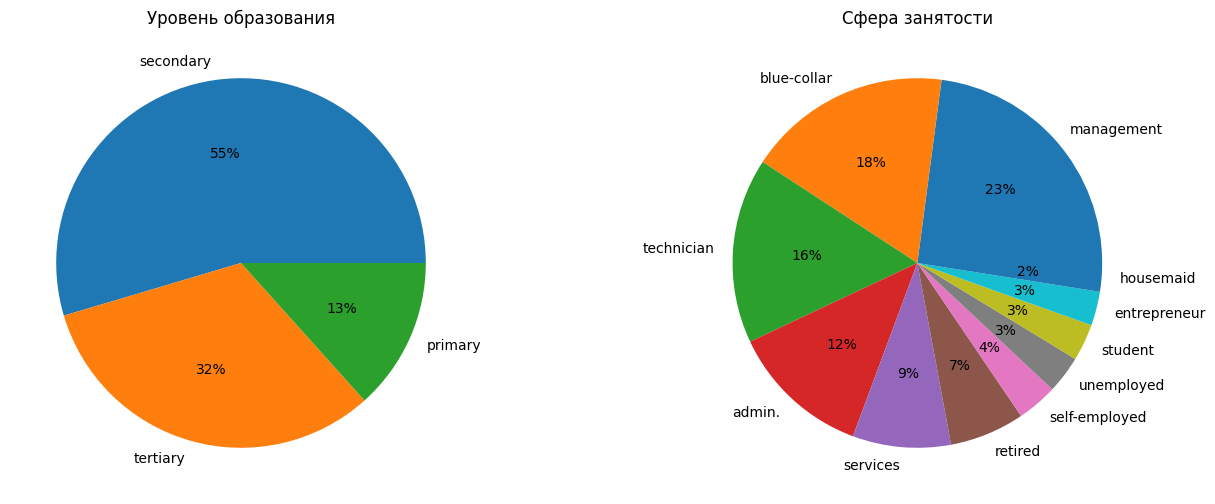

In [1516]:
fig = plt.figure(figsize=(16, 6))
ax = fig.subplots(1, 2)

ax[0].pie(
    df['education'].value_counts(),
    labels=df['education'].value_counts().index,
    autopct='%.0f%%'
)
ax[0].set_title('Уровень образования')

ax[1].pie(
    df['job'].value_counts(),
    labels=df['job'].value_counts().index,
    autopct='%.0f%%'
)
ax[1].set_title('Cфера занятости')

Больше половины клиентов банка имеют среднее оразование, примерно треть высшее и примерно одна шестая — только начальное.

Три четверти клиентов банка составляют менеджеры (23%), рабочие (18%), технические специалисты (16%), администраторы (12%) и служащие (9%).

Text(0.5, 1.0, 'Имеется ли кредит на жильё')

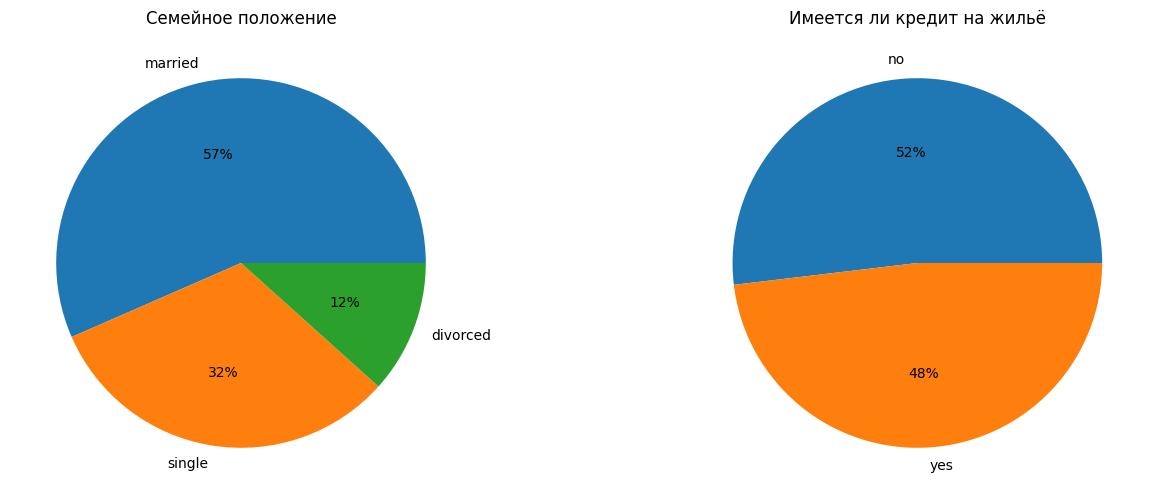

In [1517]:
fig = plt.figure(figsize=(16, 6))
ax = fig.subplots(1, 2)

ax[0].pie(
    df['marital'].value_counts(),
    labels=df['marital'].value_counts().index,
    autopct='%.0f%%'
)
ax[0].set_title('Семейное положение')

ax[1].pie(
    df['housing'].value_counts(),
    labels=df['housing'].value_counts().index,
    autopct='%.0f%%'
)
ax[1].set_title('Имеется ли кредит на жильё')

Больше половины клиентов банка имеют семью, треть — холостяки, около 12% разведены.

Чуть меньше половины клиентов имеют кредит на жилье.

Text(0.5, 1.0, 'Кредит просрочен')

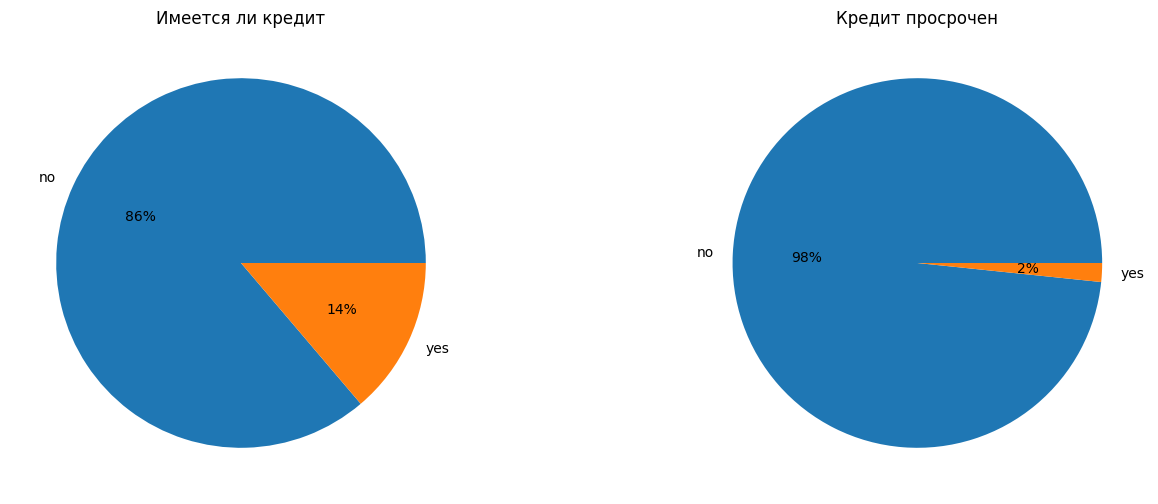

In [1518]:
fig = plt.figure(figsize=(16, 6))
ax = fig.subplots(1, 2)

ax[0].pie(
    df['loan'].value_counts(),
    labels=df['loan'].value_counts().index,
    autopct='%.0f%%'
)
ax[0].set_title('Имеется ли кредит')

ax[1].pie(
    df['default'].value_counts(),
    labels=df['default'].value_counts().index,
    autopct='%.0f%%'
)
ax[1].set_title('Кредит просрочен')

У 14% клиентов есть кредит. Менее 2% клиентов имеют просроченный кредит.

Text(0.5, 1.0, 'Месяц последнего контакта с клентом')

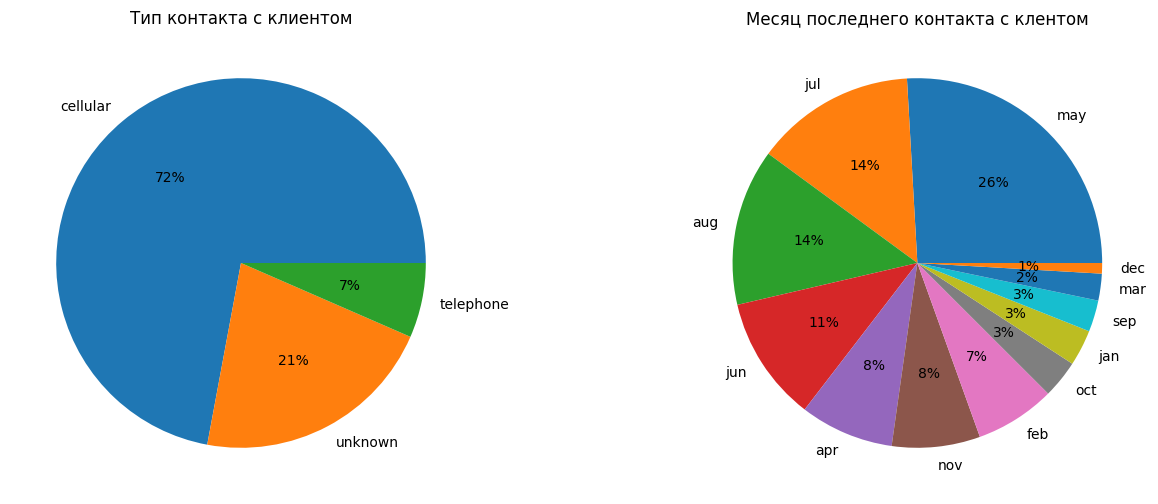

In [1519]:
fig = plt.figure(figsize=(16, 6))
ax = fig.subplots(1, 2)

ax[0].pie(
    df['contact'].value_counts(),
    labels=df['contact'].value_counts().index,
    autopct='%.0f%%'
)
ax[0].set_title('Тип контакта с клиентом')

ax[1].pie(
    df['month'].value_counts(),
    labels=df['month'].value_counts().index,
    autopct='%.0f%%'
)
ax[1].set_title('Месяц последнего контакта с клентом')

С большинством клиентов контактировали через мобильный телефон. Около 7% звонков были сделаны на домашний телефон. Для 21% клиентов свособ установления связи не установлен.

Чуть больше половины контактов приходится на три месяца май, июль и август, а меньше всего контактов (1%) на декабрь.

Text(0.5, 1.0, 'Клиент согласился открыть депозит')

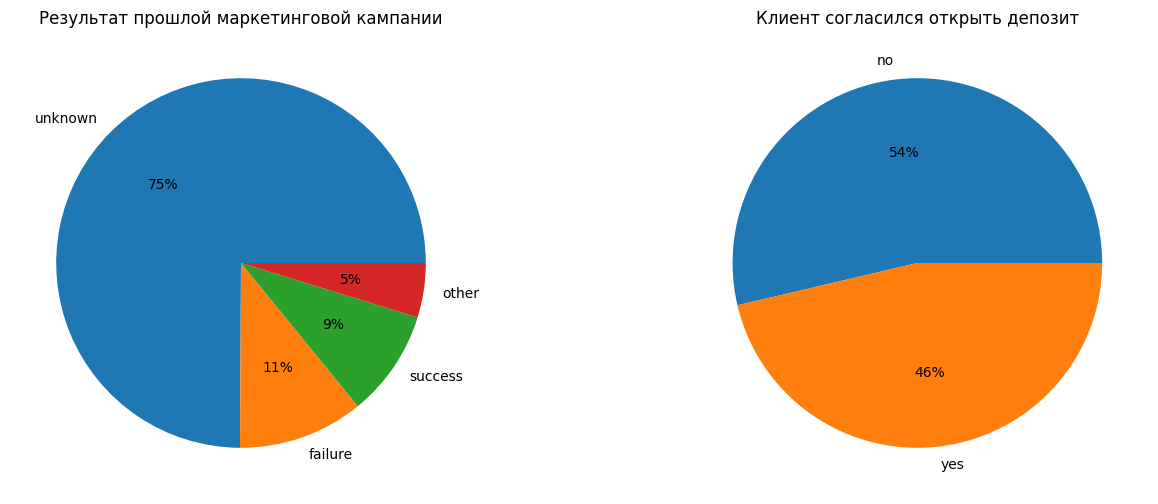

In [1520]:
fig = plt.figure(figsize=(16, 6))
ax = fig.subplots(1, 2)

ax[0].pie(
    df['poutcome'].value_counts(),
    labels=df['poutcome'].value_counts().index,
    autopct='%.0f%%'
)
ax[0].set_title('Результат прошлой маркетинговой кампании')

ax[1].pie(
    df['deposit'].value_counts(),
    labels=df['deposit'].value_counts().index,
    autopct='%.0f%%'
)
ax[1].set_title('Клиент согласился открыть депозит')

Только с 25% клиентов контактировали по поводу предыдущей маркетинговой кампании. Среди них примерно треть согласилась приобрести продукт или услугу.

Результат последней маркетинговой кампании более успешный — почти половина клиентов (46%) решили приобрести депозит.

In [1521]:
print(df['month'].value_counts())

month
may    2617
jul    1418
aug    1385
jun    1104
apr     830
nov     780
feb     709
oct     335
jan     319
sep     278
mar     237
dec      93
Name: count, dtype: int64


### Задание 6

In [1522]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
_df = df[['poutcome', 'deposit']].copy()
_df.loc[:, 'deposit_flag'] = _df['deposit'] == 'yes'

for status in ['success', 'failure', 'other']:
    percent = round(_df[_df['poutcome'] == status]['deposit_flag'].mean() * 100, 2)
    print(f'Доля успеха для статуса "{status}" составляет {percent}%')

Доля успеха для статуса "success" составляет 91.11%
Доля успеха для статуса "failure" составляет 49.32%
Доля успеха для статуса "other" составляет 55.09%


### Задание 7

In [1523]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
_df = df[['month', 'deposit']].copy()
_df.loc[:, 'deposit_flag'] = _df['deposit'] == 'yes'

deposit_by_month = _df.groupby('month')[['deposit_flag']].mean().sort_values('deposit_flag')

worst_month = deposit_by_month.iloc[0]
best_month = deposit_by_month.iloc[-1]

print(f'Чаще всего отказывались открыть депозит в месяце "{worst_month.name}"')
print(f'Кол-во отказов составило {round(100 * (1 - worst_month.values[0]), 2)}%')
print(f'Реже всего отказывались открыть депозит в месяце "{best_month.name}"')
print(f'Кол-во отказов составило {round(100 * (1 - best_month.values[0]), 2)}%')

Чаще всего отказывались открыть депозит в месяце "may"
Кол-во отказов составило 67.86%
Реже всего отказывались открыть депозит в месяце "dec"
Кол-во отказов составило 9.68%


### Задание 8

[Text(0, 0, 'До 30'),
 Text(1, 0, '31—40'),
 Text(2, 0, '41—50'),
 Text(3, 0, '51—60'),
 Text(4, 0, 'Старше 60')]

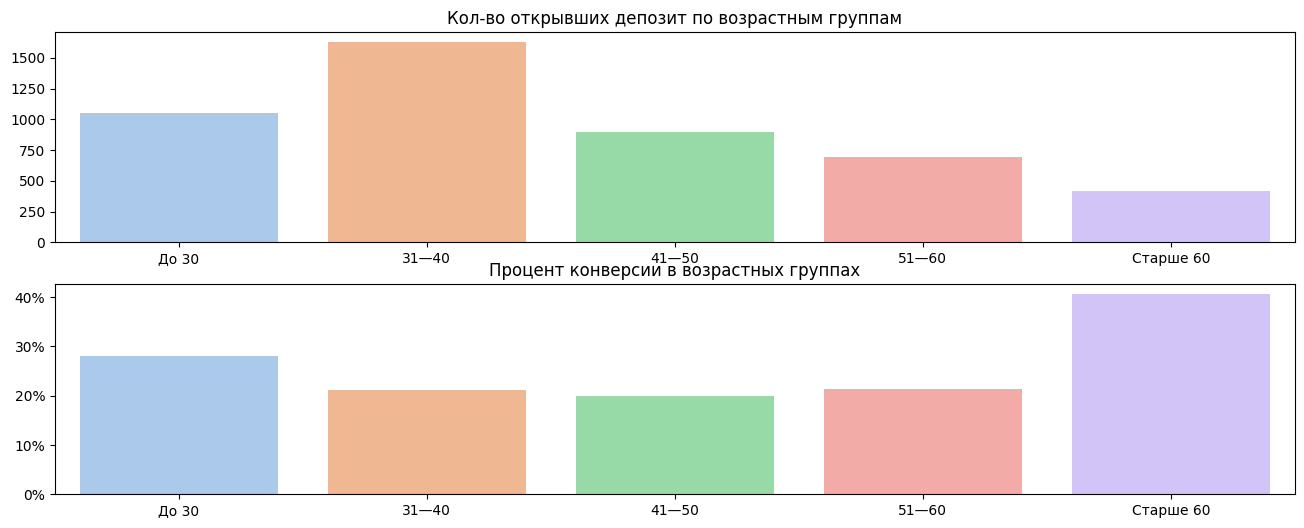

In [1524]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def calc_age_group(age):
    if age <= 30: return 1
    if age <= 40: return 2
    if age <= 50: return 3
    if age <= 60: return 4
    return 5

df.loc[:, 'age_group'] = df['age'].apply(calc_age_group)

df['deposit_flag'] = df['deposit'] == 'yes'

_df = df.groupby('age_group')['deposit_flag'].agg(['sum', 'count']).reset_index()
_df['conversion'] = _df['sum'] / _df['count']

fig = plt.figure(figsize=(16, 6))
ax = fig.subplots(2, 1)

sns.barplot(ax=ax[0], data=_df, x='age_group', y='sum', palette='pastel')
ax[0].set_title('Кол-во открывших депозит по возрастным группам')
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].set_xticklabels([
    'До 30',
    '31—40',
    '41—50',
    '51—60',
    'Старше 60',
])

sns.barplot(ax=ax[1], data=_df, x='age_group', y='conversion', palette='pastel')
ax[1].set_title('Процент конверсии в возрастных группах')
ax[1].set_ylabel('')
ax[1].set_yticklabels([str(x) + '%' for x in range(0, 71, 10)])
ax[1].set_xlabel('')
ax[1].set_xticklabels([
    'До 30',
    '31—40',
    '41—50',
    '51—60',
    'Старше 60',
])

### Задания 9 и 10

Text(0.5, 0, '')

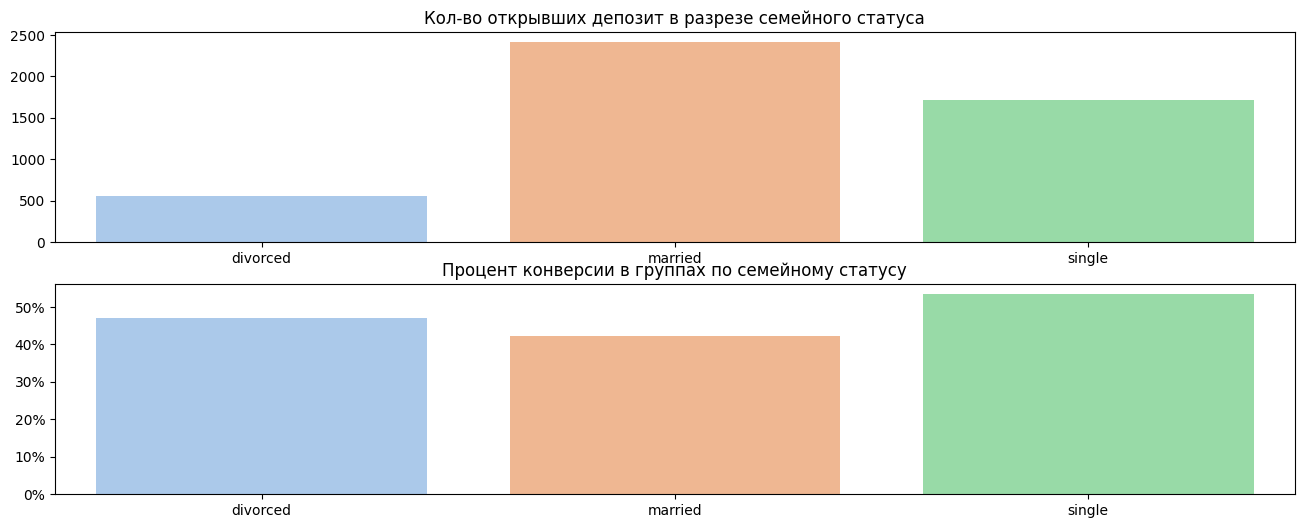

In [1525]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
_df = df.groupby('marital')['deposit_flag'].agg(['sum', 'count']).reset_index()
_df['conversion'] = _df['sum'] / _df['count']

fig = plt.figure(figsize=(16, 6))
ax = fig.subplots(2, 1)

sns.barplot(ax=ax[0], data=_df, x='marital', y='sum', palette='pastel')
ax[0].set_title('Кол-во открывших депозит в разрезе семейного статуса')
ax[0].set_ylabel('')
ax[0].set_xlabel('')


sns.barplot(ax=ax[1], data=_df, x='marital', y='conversion', palette='pastel')
ax[1].set_title('Процент конверсии в группах по семейному статусу')
ax[1].set_ylabel('')
ax[1].set_yticklabels([str(x) + '%' for x in range(0, 51, 10)])
ax[1].set_xlabel('')

Text(0.5, 0, '')

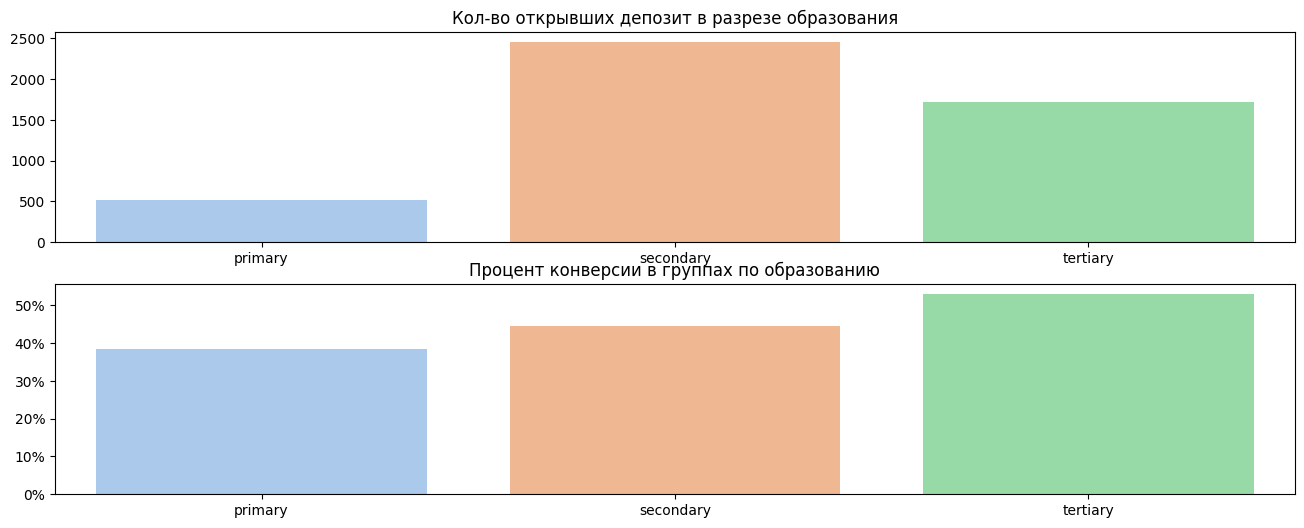

In [1526]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
_df = df.groupby('education')['deposit_flag'].agg(['sum', 'count']).reset_index()
_df['conversion'] = _df['sum'] / _df['count']

fig = plt.figure(figsize=(16, 6))
ax = fig.subplots(2, 1)

sns.barplot(ax=ax[0], data=_df, x='education', y='sum', palette='pastel')
ax[0].set_title('Кол-во открывших депозит в разрезе образования')
ax[0].set_ylabel('')
ax[0].set_xlabel('')

sns.barplot(ax=ax[1], data=_df, x='education', y='conversion', palette='pastel')
ax[1].set_title('Процент конверсии в группах по образованию')
ax[1].set_ylabel('')
ax[1].set_yticklabels([str(x) + '%' for x in range(0, 51, 10)])
ax[1].set_xlabel('')

[Text(0, 0, 'admin.'),
 Text(1, 0, 'blue-collar'),
 Text(2, 0, 'entrepreneur'),
 Text(3, 0, 'housemaid'),
 Text(4, 0, 'management'),
 Text(5, 0, 'retired'),
 Text(6, 0, 'self-employed'),
 Text(7, 0, 'services'),
 Text(8, 0, 'student'),
 Text(9, 0, 'technician'),
 Text(10, 0, 'unemployed')]

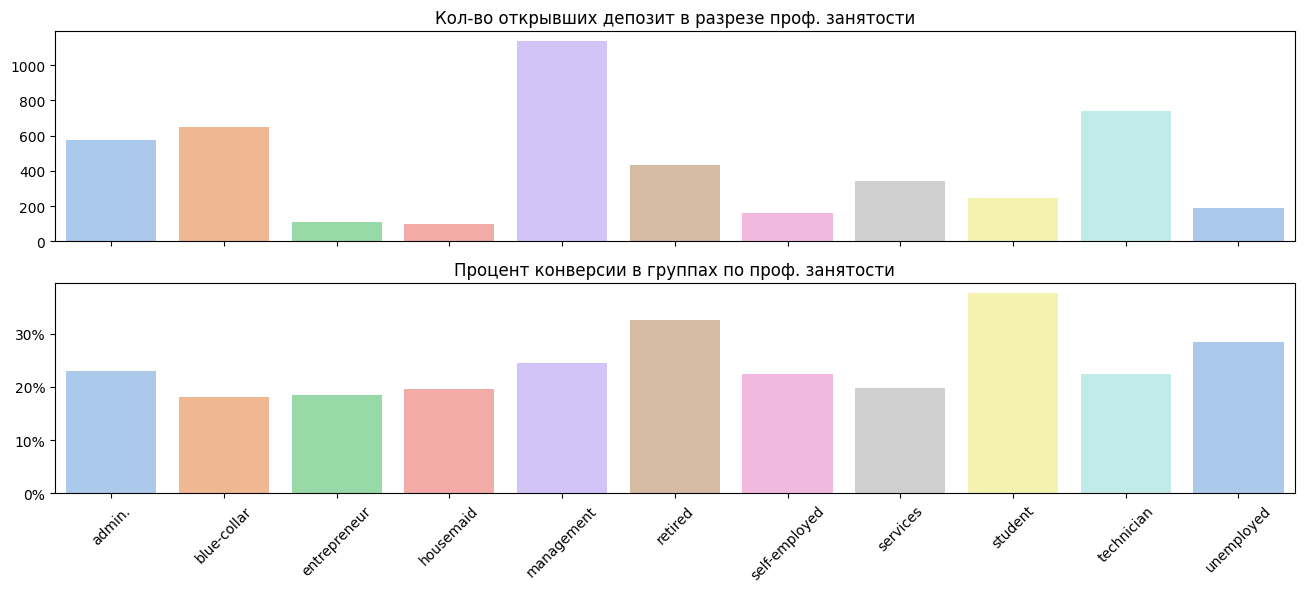

In [1527]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
_df = df.groupby('job')['deposit_flag'].agg(['sum', 'count']).reset_index()
_df['conversion'] = _df['sum'] / _df['count']

fig = plt.figure(figsize=(16, 6))
ax = fig.subplots(2, 1)

sns.barplot(ax=ax[0], data=_df, x='job', y='sum', palette='pastel')
ax[0].set_title('Кол-во открывших депозит в разрезе проф. занятости')
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].set_xticklabels(['' for _label in ax[0].get_xticklabels()])

sns.barplot(ax=ax[1], data=_df, x='job', y='conversion', palette='pastel')
ax[1].set_title('Процент конверсии в группах по проф. занятости')
ax[1].set_ylabel('')
ax[1].set_yticklabels([str(x) + '%' for x in range(0, 71, 10)])
ax[1].set_xlabel('')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)

In [1528]:
_df = df[df['deposit'] == 'yes']
_df = _df.pivot_table('deposit', index='education', columns='marital', aggfunc='count')
_df

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


### Задание 11

Text(70.72222222222221, 0.5, '')

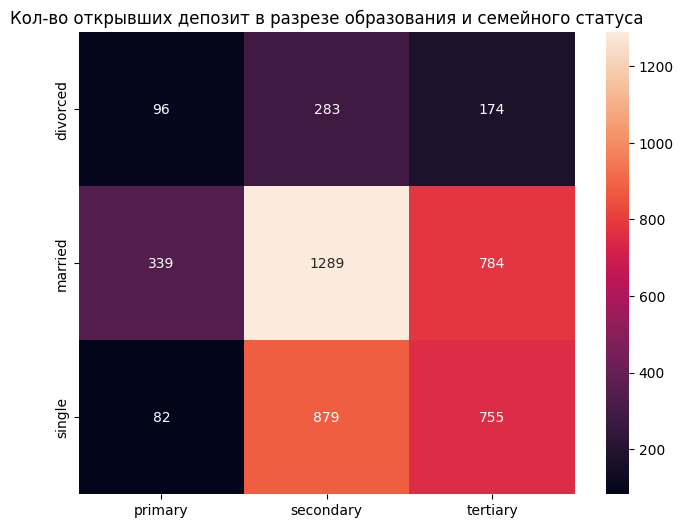

In [1529]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

_df = df[df['deposit'] == 'yes'][['marital', 'education']].copy()

_df = pd.crosstab(_df['marital'], _df['education'])
_df.reset_index(inplace=True)
_df.set_index('marital', inplace=True)

fig = plt.figure(figsize=(8, 6))
ax = fig.subplots()

sns.heatmap(ax=ax, data=_df, annot=True, fmt='')
title = 'Кол-во открывших депозит в разрезе образования и семейного статуса'
ax.set_title(title)
ax.set_xlabel('')
ax.set_ylabel('')

Text(70.72222222222221, 0.5, '')

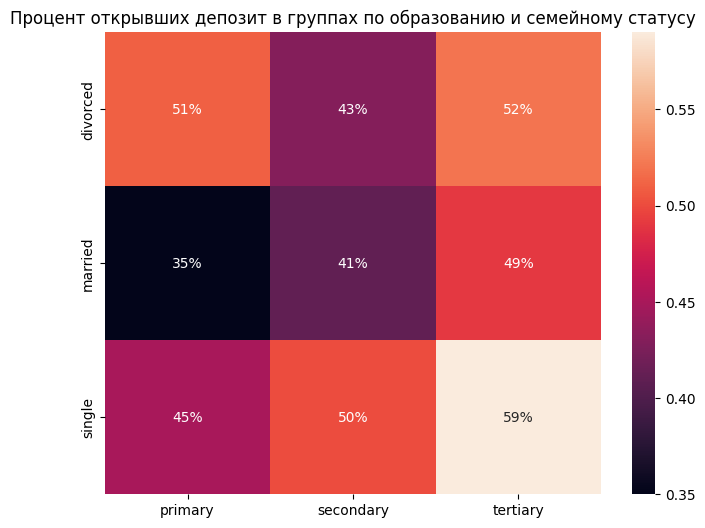

In [1530]:
__df = df[['marital', 'education']].copy()

__df = pd.crosstab(__df['marital'], __df['education'])
__df.reset_index(inplace=True)
__df.set_index('marital', inplace=True)

fig = plt.figure(figsize=(8, 6))
ax = fig.subplots()

data = _df / __df

data = data.round(2)

sns.heatmap(ax=ax, data=data, annot=True, fmt='.0%')
title = 'Процент открывших депозит в группах по образованию и семейному статусу'
ax.set_title(title)
ax.set_xlabel('')
ax.set_ylabel('')

## Часть 3: преобразование данных

### Задание 1

In [1531]:
def apply_label_encoder(data, columns, encoder=None):
    if encoder is None:
        encoder = preprocessing.LabelEncoder()
    data.loc[:, columns] = encoder.fit_transform(data[columns])
    return encoder

In [1532]:
# преобразуйте уровни образования
_encoder = apply_label_encoder(df, ['education'])

df['education'].sum()

11995

### Задания 2 и 3

In [1533]:
# преобразуйте бинарные переменные в представление из нулей и единиц
yes_no_columns = ['default', 'housing', 'loan', 'deposit']

for col in yes_no_columns:
    df.loc[:, col] = df[col].apply(lambda x: 1 if x == 'yes' else 0)

df.drop(columns=['deposit_flag'], inplace=True)

In [1534]:
deposit_std = round(df['deposit'].std(), 3)
print(f'Стандартное отклонение в признаке `deposit`: {deposit_std}')

# Вычислите среднее арифметическое для каждой из получившихся переменных,
# сложите три результата и в качестве ответа впишите итог,
# округлив его до трёх знаков после точки-разделителя.
three_columns = ['default', 'housing', 'loan']
three_columns_joined = ', '.join([f'`{x}`' for x in three_columns])
three_columns_avg_sum = round(df[three_columns].mean().sum(), 3)
print(f'Сумма средних арифметических признаков {three_columns_joined}:  {three_columns_avg_sum}')

Стандартное отклонение в признаке `deposit`: 0.499
Сумма средних арифметических признаков `default`, `housing`, `loan`:  0.635


### Задание 4

In [1535]:
# создайте дамми-переменные
columns_to_apply_dummies = ['job', 'marital', 'contact', 'month', 'poutcome']

dummies = pd.get_dummies(df[columns_to_apply_dummies])

df.loc[:, dummies.columns] = dummies

# Сколько теперь всего признаков в датасете, не считая целевую переменную?
# Введите ответ, посчитав уже добавленные dummy-переменные,
# но до удаления номинальных.

print(f'Признаков в датасете (не считая целевого): {df.shape[1] - 1}')

Признаков в датасете (не считая целевого): 50


### Задания 5 и 6

In [1536]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,4,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,4,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,3,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
3,55,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,4,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
4,54,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,4,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True


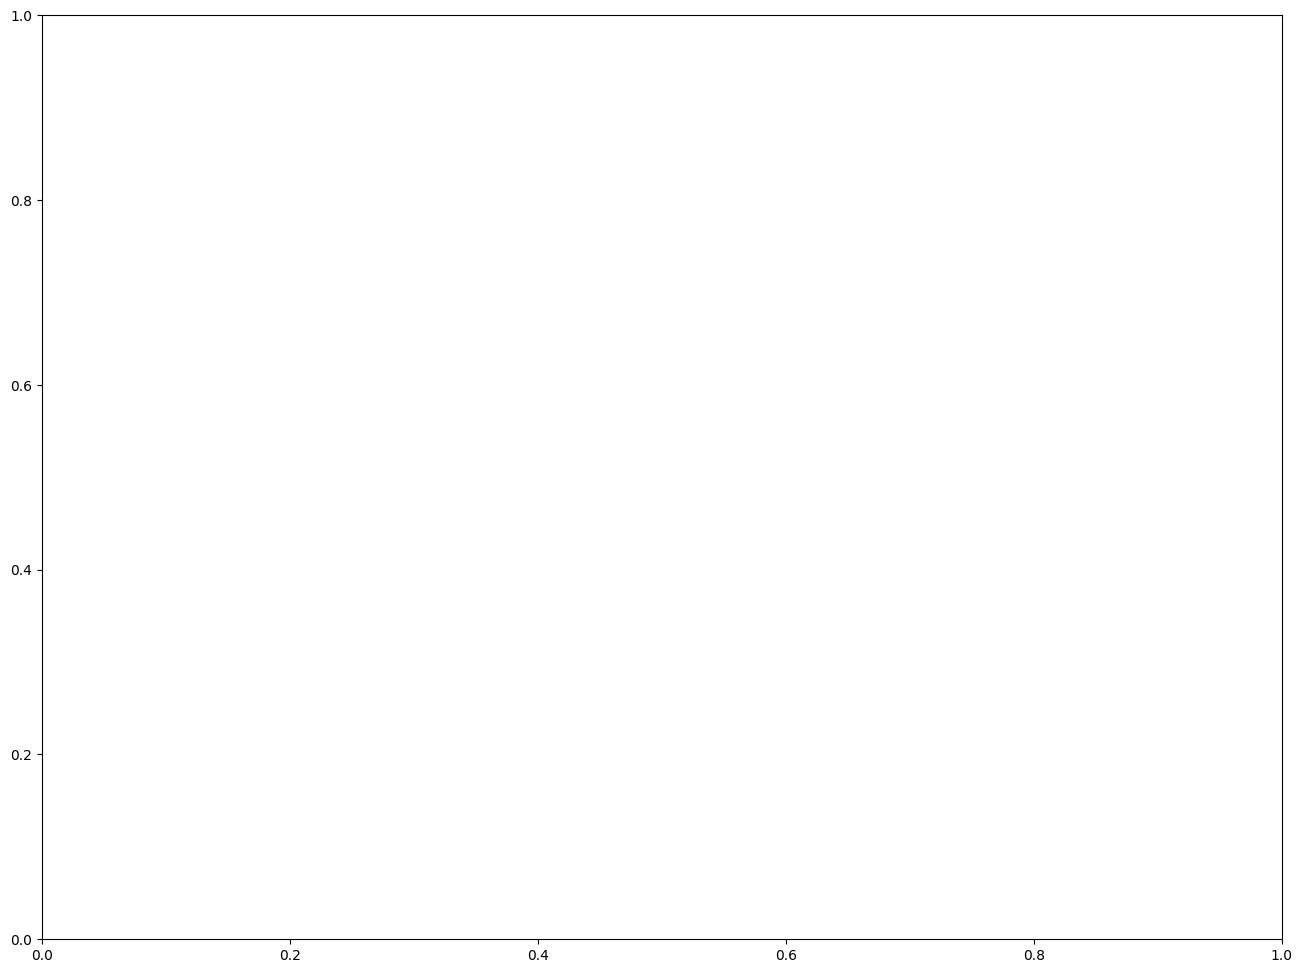

In [1537]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
fig = plt.figure(figsize=(16, 12))
ax = fig.subplots()

#sns.heatmap(ax=ax, data=df.corr(), annot=False, mask=None);


Text(0.5, 1.0, 'Коэфициенты корреляции')

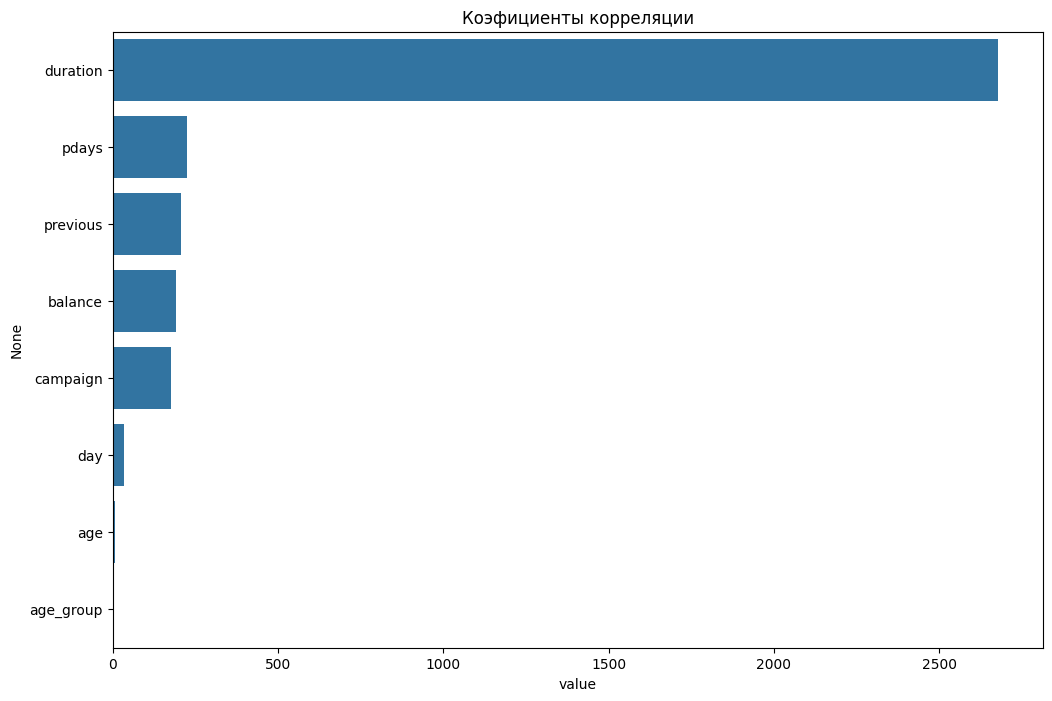

In [1538]:
data = df.copy()
X = data.drop(columns=['deposit'])
y = data['deposit']

num_cols = X.select_dtypes(include='number').columns

f_classif_results = f_classif(X[num_cols], y)

data = pd.DataFrame(data=f_classif_results[0], index=num_cols, columns=['value'])
data.sort_values(by=['value'], inplace=True, ascending=False)

fig = plt.figure(figsize=(12, 8))
ax = fig.subplots()

sns.barplot(ax=ax, data=data, x='value', y=data.index);
ax.set_title('Коэфициенты корреляции')

### Задания 7 и 8

In [1539]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [1540]:
X_train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,age_group,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
7287,34,management,married,2,0,557.0,1,0,cellular,16,jul,513,1,-1,0,unknown,2,False,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True
4766,34,admin.,married,2,0,69.0,0,1,cellular,25,nov,296,1,205,2,failure,2,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False
5712,33,management,single,2,0,0.0,1,0,telephone,5,may,399,2,358,5,other,2,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False
2530,37,student,single,1,0,444.0,0,0,cellular,14,aug,137,1,102,5,success,2,False,False,False,False,False,False,False,False,True,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
9294,39,housemaid,married,1,0,1444.0,0,0,cellular,19,nov,100,1,117,8,success,2,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7382,30,management,single,2,0,222.0,0,1,cellular,4,feb,111,1,204,2,other,1,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False
1056,53,blue-collar,married,1,0,1777.0,1,0,cellular,21,nov,796,5,154,1,failure,4,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False
2931,76,retired,married,0,0,3324.0,0,0,cellular,13,nov,122,1,92,3,success,5,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
7735,29,admin.,single,1,0,209.0,0,0,cellular,5,feb,605,2,-1,0,unknown,1,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True


In [1541]:
# рассчитайте необходимые показатели
print(f'Размер тестовой выборки: {X_test.shape[0]}')
deposit_mean = y_test.mean()
print(f'Среднее значение целевой переменной на тестовой выборке: {round(deposit_mean, 2)}')

Размер тестовой выборки: 3335
Среднее значение целевой переменной на тестовой выборке: 0.46


### Задание 9

In [1542]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
numeric_columns = X_train.select_dtypes(include='number').columns
selector.fit(X_train[numeric_columns], y_train)
best_features = selector.get_feature_names_out()

print('15 лучших признаков:')
print(*[f'  - `{x}`' for x in best_features], sep='\n')

15 лучших признаков:
  - `age`
  - `balance`
  - `day`
  - `duration`
  - `campaign`
  - `pdays`
  - `previous`
  - `age_group`


In [1543]:
# fix для дальнейшего прохождения, в то версии библиотек не совпадают

best_features = ['balance','housing','duration','campaign','pdays','previous','age_group','contact_cellular','contact_unknown','month_mar','month_may','month_oct','month_sep','poutcome_success','poutcome_unknown']

X_train = X_train[best_features]
X_test = X_test[best_features]

### Задание 10

In [1544]:
# нормализуйте данные с помощью minmaxsxaler
from sklearn import preprocessing as ce

# RobustScaler - нормализация
# MinMaxScaler - нормализация
# StandardScaler - стандартизация
# (Если разброс данных не очень большой, то можно не делать трансформацию.)
# Если данные НЕ распределены нормально, нужна нормализация,
# иначе — стандартизация

scaler = preprocessing.MinMaxScaler()
scaler.fit(X[best_features])

def normalize_data(X, scaler):
    X_transformed = X.copy()
    columns_to_scale = X_transformed.columns.to_list()
    # create scaler once and fit it to some initial data

    # use the scaler for data (once or many times)
    ndarr = scaler.transform(X_transformed[columns_to_scale])
    # create a DataFrame out of ndarr
    norm_df = pd.DataFrame(ndarr, columns=columns_to_scale).set_index(X_transformed.index)
    # update the transformed columns data
    X.loc[:, columns_to_scale] = norm_df[columns_to_scale]

normalize_data(X_train, scaler)
normalize_data(X_test, scaler)

# Рассчитайте среднее арифметическое для первого предиктора
# (т. е. для первого столбца матрицы) из тестовой выборки.
# Ответ округлите до двух знаков после точки-разделителя.

first_column = X_test.columns[0]
first_column_mean = X_test[first_column].mean()

print(f'Среднее арифметическое первого предиктера: {round(first_column_mean, 2)}')

Среднее арифметическое первого предиктера: 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [1545]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6770 entries, 7287 to 4966
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   balance           6770 non-null   float64
 1   housing           6770 non-null   object 
 2   duration          6770 non-null   float64
 3   campaign          6770 non-null   float64
 4   pdays             6770 non-null   float64
 5   previous          6770 non-null   float64
 6   age_group         6770 non-null   float64
 7   contact_cellular  6770 non-null   float64
 8   contact_unknown   6770 non-null   float64
 9   month_mar         6770 non-null   float64
 10  month_may         6770 non-null   float64
 11  month_oct         6770 non-null   float64
 12  month_sep         6770 non-null   float64
 13  poutcome_success  6770 non-null   float64
 14  poutcome_unknown  6770 non-null   float64
dtypes: float64(14), object(1)
memory usage: 846.2+ KB


In [1546]:
y_train.head()

7287    0
4766    1
5712    0
2530    1
9294    0
Name: deposit, dtype: object

In [1547]:
#X_train.info()
X_train['housing']= X_train['housing'].astype('float64')
y_train=y_train.astype('float64')
y_test=y_test.astype('float64')

In [1548]:
# обучите логистическую регрессию и рассчитайте метрики качества

log_reg = linear_model.LogisticRegression(
    random_state=42,
    max_iter=1000,
    solver='sag', # численный метод оптимизации функции потерь
)

log_reg.fit(X_train, y_train)

# Для получившейся модели вычислите значение accuracy на тестовой выборке.
# Ответ округлите до двух знаков после точки-разделителя.

y_test_pred = log_reg.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred);

print(f'Accuracy: {round(test_accuracy, 4)}')

Accuracy: 0.8012


### Задания 2,3,4

In [1549]:
# обучите решающие деревья, настройте максимальную глубину
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
)

dt_clf.fit(X_train, y_train);

y_test_pred = dt_clf.predict(X_test);
print(f'F₁ score for X_test: {metrics.f1_score(y_test, y_test_pred)}')

y_train_pred = dt_clf.predict(X_train);
print(f'F₁ score for X_train: {metrics.f1_score(y_train, y_train_pred)}')

F₁ score for X_test: 0.7272727272727273
F₁ score for X_train: 1.0


In [1550]:
def train_and_estimate_dt(max_depth):
    dt_clf = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_depth=max_depth,
        random_state=42,
    )

    dt_clf.fit(X_train, y_train);
    y_test_pred = dt_clf.predict(X_test);
    y_train_pred = dt_clf.predict(X_train);

    print(f'\nFor max_depth={max_depth}:')
    print(f'- F₁ score for X_test: {metrics.f1_score(y_test, y_test_pred)}')
    print(f'- F₁ score for X_train: {metrics.f1_score(y_train, y_train_pred)}')
    print(f'- Accuracy for X_test: {metrics.accuracy_score(y_test, y_test_pred)}')

for max_depth in range(1, 20):
    train_and_estimate_dt(max_depth)


For max_depth=1:
- F₁ score for X_test: 0.7194038406420178
- F₁ score for X_train: 0.728712321155716
- Accuracy for X_test: 0.7064467766116942

For max_depth=2:
- F₁ score for X_test: 0.6379376683339746
- F₁ score for X_train: 0.6466512702078522
- Accuracy for X_test: 0.7178410794602699

For max_depth=3:
- F₁ score for X_test: 0.7760233918128655
- F₁ score for X_train: 0.7822094691535151
- Accuracy for X_test: 0.7703148425787106

For max_depth=4:
- F₁ score for X_test: 0.7757965507161648
- F₁ score for X_train: 0.7823841629608378
- Accuracy for X_test: 0.7700149925037482

For max_depth=5:
- F₁ score for X_test: 0.7821122740247384
- F₁ score for X_train: 0.7937247592420006
- Accuracy for X_test: 0.7940029985007496

For max_depth=6:
- F₁ score for X_test: 0.7865384615384615
- F₁ score for X_train: 0.7995601633678919
- Accuracy for X_test: 0.8002998500749625

For max_depth=7:
- F₁ score for X_test: 0.7842227378190255
- F₁ score for X_train: 0.8063885267275098
- Accuracy for X_test: 0.804

### Задание 5

In [1551]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth':[3,5,7],
}

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        # неизменяемые параметры
        criterion='entropy',
        random_state=42,
    ),
    param_grid=param_grid,
)

grid_search.fit(X_train, y_train)

# наилучшая комбинация гиперпараметров
print(grid_search.best_params_)

# метрика на тестовой выборке
print(grid_search.score(X_test, y_test))

# Оцените метрику  на тестовой выборке для наилучшей комбинации перебираемых параметров. 
# В качестве ответа впишите значение метрики. Ответ округлите до двух знаков после точки-разделителя.
y_test_pred = grid_search.predict(X_test)
f1_test = metrics.f1_score(y_test, y_test_pred)

print(f'F₁ score for X_test: {round(f1_test, 3)}')

#0.79

{'max_depth': 7, 'min_samples_split': 5}
0.8038980509745127
F₁ score for X_test: 0.783


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [1552]:
# обучите на ваших данных случайный лес
rf_clf = ensemble.RandomForestClassifier(
    n_estimators=100, # число деревьев
    criterion='gini',
    max_depth=10,
    min_samples_leaf=5,
    random_state=42
)

rf_clf.fit(X_train, y_train)

y_test_pred = rf_clf.predict(X_test)

# Оцените метрики accuracy и recall для построенной модели на тестовой выборке. 
# В качестве ответов введите значения метрик. Ответ округлите до двух знаков после точки-разделителя.

# from sklearn import metrics
# import seaborn as sns

accuracy = metrics.accuracy_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test, y_test_pred)

print(f'Accuracy: {round(accuracy, 2)}')
print(f'Recall: {round(recall, 2)}')

Accuracy: 0.83
Recall: 0.83


### Задания 2 и 3

In [1553]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gbr = ensemble.GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42,
)

gbr.fit(X_train, y_train);

# Для построенной модели оцените метрику F1 на тестовой выборке.
# В качестве ответа впишите значение метрики.
# Ответ округлите до двух знаков после точки-разделителя.

f1 = metrics.f1_score(y_test, gbr.predict(X_test))
#print(f'F₁ score: {f1}')
print(f'F₁ score: {round(f1, 2)}')

F₁ score: 0.81


### Задание 4

In [1554]:
# объедините уже известные вам алгоритмы с помощью стекинга 
# список базовых моделей
log_reg = linear_model.LogisticRegression(
    random_state=42,
    max_iter=1000,
    solver='sag',
)

dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=7,
    min_samples_split=5,
)

gbr = ensemble.GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42,
)

estimators = [
    ('log_reg', log_reg),
    ('dt_clf', dt_clf),
    ('gbr', gbr),
]

# метамодель
final_estimator = linear_model.LogisticRegression(
    random_state=42
)

# объект класса стекинг
reg = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
)

reg.fit(X_train, y_train)

StackingClassifier(estimators=[('log_reg',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42,
                                                   solver='sag')),
                               ('dt_clf',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=7,
                                                       min_samples_split=5,
                                                       random_state=42)),
                               ('gbr',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(random_state=42))

In [1555]:
# Для построенной модели оцените метрику precision на тестовой выборке.
# В качестве ответа впишите значение метрики. Ответ округлите
# до двух знаков после точки-разделителя.

y_test_pred = reg.predict(X_test)

precision = metrics.precision_score(y_test, y_test_pred)

print(f'Precision: {round(precision, 2)}')
#0.82

Precision: 0.81


### Задание 5

In [1559]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
def find_K_best_with_RFE(X, y, estimator, k):
    selector = RFE(estimator, step=1, n_features_to_select=k)
    selector = selector.fit(X_train, y_train)
    return selector.get_feature_names_out()

estimator = ensemble.GradientBoostingClassifier()
features_counter = Counter([])

# Для экономии времени посчитаем только первые пять
for k in range(1, 6):
    best_features = find_K_best_with_RFE(X_train, y_train, estimator, k)
    features_counter.update(best_features)

features_by_importance = features_counter.most_common()
feature_names_by_importance = [x[0] for x in features_by_importance]

print('Признаки по важности для модели градиентного бустинга')
print(*[f'- `{x}`' for x in feature_names_by_importance], sep='\n')

NameError: name 'RFE' is not defined

### Задания 6,7,8

In [1560]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
def calc_log_res_params(all_params):
    n_estimators = all_params['n_estimators']
    max_depth = all_params['max_depth']
    min_samples_leaf = all_params['min_samples_leaf']

    res_params = {
        'criterion': 'gini',
        'random_state': 42,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_leaf': min_samples_leaf,
    }

    return res_params

def optuna_rf_log_reg(trial):
    # задаем пространство поиска
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # динамически вычисляем параметры
    res_params = calc_log_res_params({
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_leaf': min_samples_leaf,
    })

    # создае модель
    rf_clf = ensemble.RandomForestClassifier(**res_params)

    # обучаем модель с помощью кросс-валидации
    score = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()

    return score

# создаем процесс обучения и запускаем его
study = optuna.create_study(study_name='Optuna: Logistic regression', direction='maximize')

study.optimize(optuna_rf_log_reg, n_trials=15)

# при необходимости выполняем дополнтиельные итерации
# study.optimize(optuna_rf_log_reg, n_trials=10)

print('Наилучшие значения гиперпараметров')
print(study.best_params)

NameError: name 'optuna' is not defined